Converting /users/gangmuk/projects/client/gangmuk-test/exp-checkoutcart/bg30/SLATE-with-jumping-global-13/349RPS-10s.checkoutcart.west.results.bin to /users/gangmuk/projects/client/gangmuk-test/exp-checkoutcart/bg30/SLATE-with-jumping-global-13//349RPS-10s.checkoutcart.west.results.bin.csv...
Created CSV file: /users/gangmuk/projects/client/gangmuk-test/exp-checkoutcart/bg30/SLATE-with-jumping-global-13//349RPS-10s.checkoutcart.west.results.bin.csv
Converting /users/gangmuk/projects/client/gangmuk-test/exp-checkoutcart/bg30/SLATE-with-jumping-global-13/608RPS-10s.checkoutcart.south.results.bin to /users/gangmuk/projects/client/gangmuk-test/exp-checkoutcart/bg30/SLATE-with-jumping-global-13//608RPS-10s.checkoutcart.south.results.bin.csv...
Created CSV file: /users/gangmuk/projects/client/gangmuk-test/exp-checkoutcart/bg30/SLATE-with-jumping-global-13//608RPS-10s.checkoutcart.south.results.bin.csv
Converting /users/gangmuk/projects/client/gangmuk-test/exp-checkoutcart/bg30/SLATE-with-jum

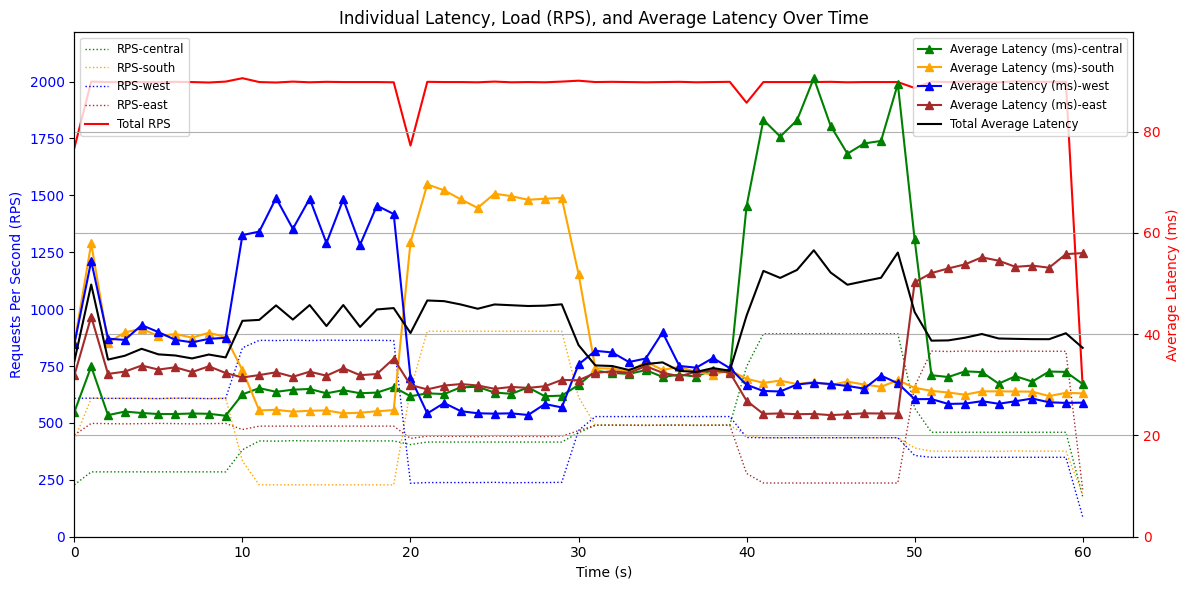

In [44]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

color = {"west": "blue", "central": "green", "east": "brown", "south": "orange"}

def encode_binary_to_csv(input_bin, output_csv):
    print(f"Converting {input_bin} to {output_csv}...")
    try:
        with open(output_csv, "w") as outfile:
            subprocess.run(
                ["vegeta", "encode", "--to", "csv", input_bin],
                stdout=outfile,
                check=True
            )
        print(f"Created CSV file: {output_csv}")
    except subprocess.CalledProcessError:
        print(f"Error converting {input_bin} to CSV. Ensure Vegeta is installed.")
        sys.exit(1)


def csv_to_df(csv_file, cluster):
    """Load a CSV file into a DataFrame with appropriate column names."""
    column_names = [
        "Timestamp", "HTTP Status", "Request Latency", "Bytes Out", "Bytes In",
        "Error", "Base64 Body", "Attack Name", "Sequence Number", "Method", "URL", "Headers"
    ]
    df = pd.read_csv(csv_file, header=None, names=column_names)
    df["Cluster"] = cluster
    return df


def plot_latency_and_load(merged_df):
    merged_df["Request Latency (ms)"] = merged_df["Request Latency"] / 1e6
    merged_df["Start Time (s)"] = (merged_df["Timestamp"] - merged_df["Timestamp"].min()) / 1e9
    merged_df["Time (s)"] = merged_df["Start Time (s)"].astype(int)
    merged_df["Request Latency (ms)"] = merged_df["Request Latency"] / 1e6
    merged_df["Start Time (s)"] = (merged_df["Timestamp"] - merged_df["Timestamp"].min()) / 1e9
    merged_df["Time (s)"] = merged_df["Start Time (s)"].astype(int)
    rps_per_second = merged_df.groupby(["Cluster", "Time (s)"]).size()
    merged_df["RPS"] = merged_df["Time (s)"].map(rps_per_second)
    merged_df.to_csv("merged_df.csv")

    
    max_average_latency = 0
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    for cluster in merged_df["Cluster"].unique():
        df_cluster = merged_df[merged_df["Cluster"] == cluster]
        print(f"Cluster: {cluster}")
        aggregated = df_cluster.groupby(["Time (s)"]).agg(RPS=("Time (s)", "count"), AvgLatency=("Request Latency (ms)", "mean")).reset_index()
        print("Plotting individual latencies, RPS, and average latency...")
        ax1.plot(aggregated["Time (s)"], aggregated["RPS"], label=f"RPS-{cluster}", color=color[cluster], linewidth=1, linestyle=":")
        # ax2.scatter(df_cluster["Start Time (s)"], df_cluster["Request Latency (ms)"], label=f"Individual Request Latency-{cluster}", color=color[cluster], alpha=0.05, zorder=1)
        ax2.plot(aggregated["Time (s)"], aggregated["AvgLatency"], label=f"Average Latency (ms)-{cluster}",color=color[cluster], linewidth=1.5, marker="^", markersize=6)
        max_average_latency = max(max_average_latency, aggregated["AvgLatency"].max())
    
    total_rps = merged_df.groupby(["Time (s)"]).size()
    total_avg_latency = merged_df.groupby(["Time (s)"]).agg(AvgLatency=("Request Latency (ms)", "mean")).reset_index()
    
    # ax1.set_ylim(0, 1.1 * total_rps.max()*1.1)
    # ax2.set_ylim(0, 1.1 * total_avg_latency.max()*1.1)
    
    
    ax1.plot(total_rps, color="red", linewidth=1.5, label="Total RPS")
    ax2.plot(total_avg_latency["Time (s)"], total_avg_latency["AvgLatency"], color="black", linewidth=1.5, label="Total Average Latency")
    
    ax1.set_xlabel("Time (s)")
    ax1.set_xlim(left=0)
    ax1.set_ylabel("Requests Per Second (RPS)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax2.set_ylabel("Average Latency (ms)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax1.set_ylim(0, 1.1 * total_rps.max())
    ax2.set_ylim(0, 1.1 * max_average_latency)
    ax1.legend(loc="upper left", fontsize="small")
    ax2.legend(loc="upper right", fontsize="small")
    plt.title("Individual Latency, Load (RPS), and Average Latency Over Time")
    plt.grid()
    plt.tight_layout()
    output_plot = "latency_rps_avg_plot.png"
    plt.savefig(output_plot)
    plt.show()


input_dir = "/users/gangmuk/projects/client/gangmuk-test/exp-checkoutcart/bg30/SLATE-with-jumping-global-13/"
if not os.path.isdir(input_dir):
    print(f"Error: {input_dir} is not a valid directory.")
    sys.exit(1)

output_csv = {}
for bin_file in [f for f in os.listdir(input_dir) if f.endswith(".results.bin")]:
    input_bin = os.path.join(input_dir, bin_file)
    output_csv = f"{input_dir}/{bin_file}.csv"
    encode_binary_to_csv(input_bin, output_csv)

merged_df = pd.DataFrame()
for csv_file in [f for f in os.listdir(input_dir) if f.endswith(".results.bin.csv")]:
    cluster = csv_file.split(".")[-4]
    if cluster not in ["west", "central", "east", "south"]:
        print(f"Error: Cluster name {cluster} is not valid.")
        break
    temp_df = csv_to_df(f"{input_dir}/{csv_file}", cluster)
    merged_df = pd.concat([merged_df, temp_df])

plot_latency_and_load(merged_df)

